# Multinomial Logit Model on Jazz Solo Data
Author: Brody Holt

Original Data: https://jazzomat.hfm-weimar.de/dbformat/dbcontent.html

The goal is to use a multinomial logistic regression model to classify Jazz solo styles based on harmonic tones, musical tempo, and the year of release.


In [115]:
import numpy as np
import pandas as pd 
import statsmodels.formula.api as smf
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from statsmodels.stats.api import anova_lm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.datasets import make_classification
import matplotlib as mpl
import matplotlib.pyplot as plt
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr, data
from rpy2.robjects.packages import importr
pandas2ri.activate()
vgam = importr('VGAM')
stats4 = importr('stats4')
splines = importr('splines')
base = importr("base")


In [116]:
data = pd.read_csv("data.csv")

# Data Visualization

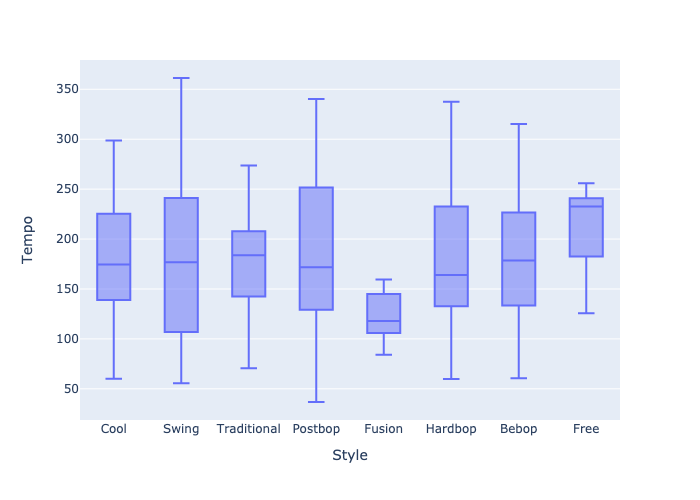

In [117]:
fig1 = px.box(data,x="Style",y="Tempo")
fig1.show("png")

Tempo is relatively similar among the distributions of styles. Fusion is slower on average and Free jazz is faster on average.

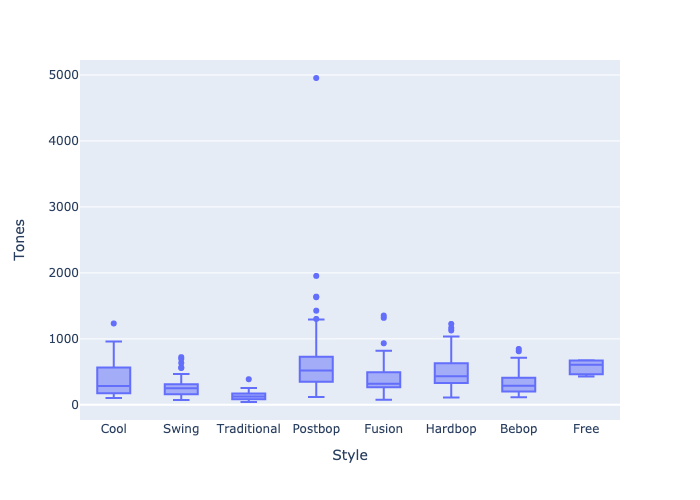

In [118]:
fig2 = px.box(data,x="Style",y="Tones")
fig2.show("png")

We see some variation in the average number of harmonic tones.

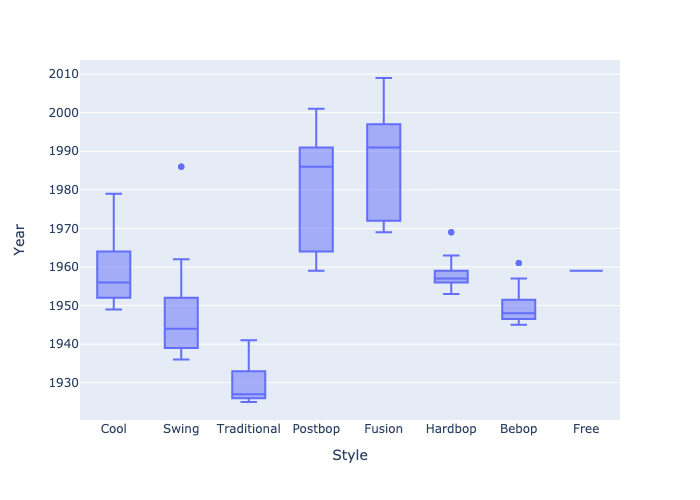

In [119]:
fig3 = px.box(data,x="Style",y="Year")
fig3.show("png")

Quite a bit of variation among the styles based on release year. This makes sense since bebop and swing were popular and prominent in the 1940s and 50s, while styles like fusion jazz came up later.

In order to prevent too much correlation between style and year, I'll focus on the styles of cool, swing, hardbop and bebop.

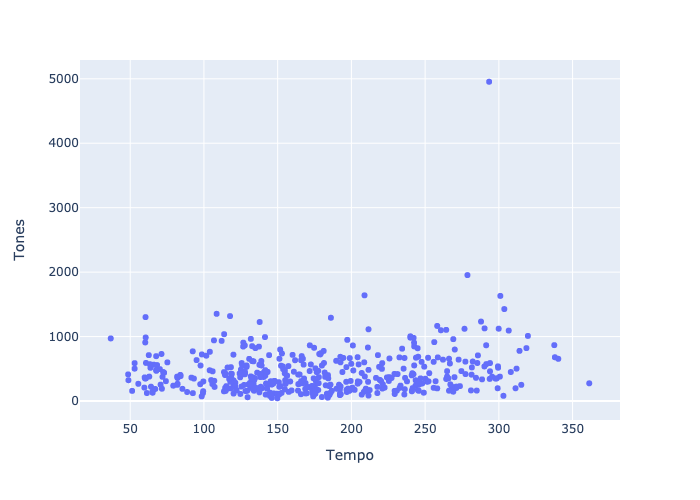

In [120]:
px.scatter(data,x="Tempo",y="Tones").show("png")

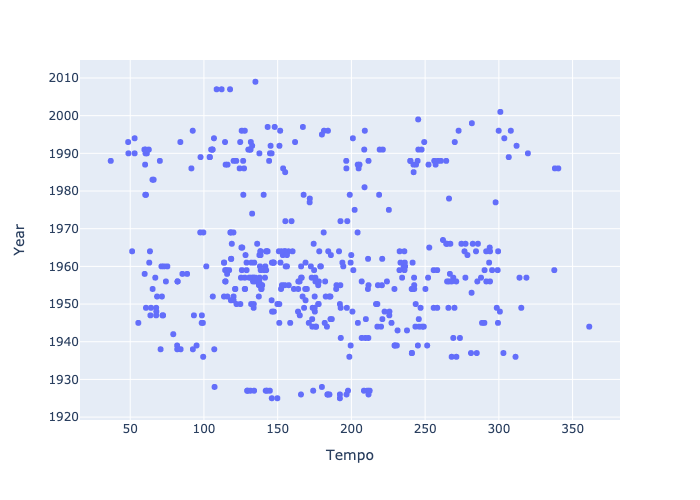

In [121]:
px.scatter(data,x="Tempo",y="Year").show("png")


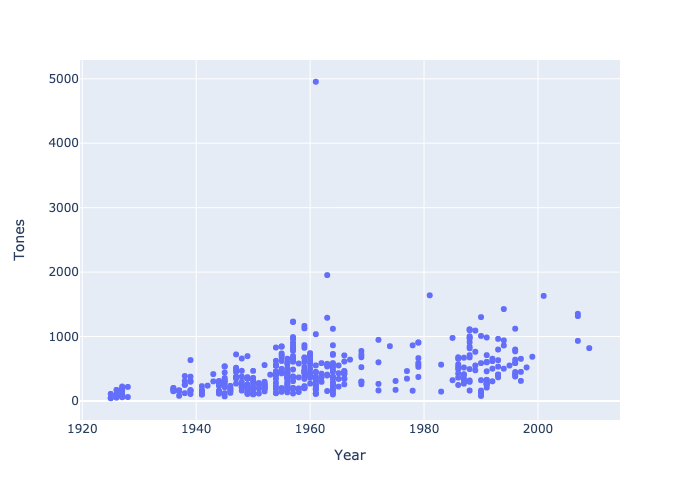

In [122]:
px.scatter(data,x="Year",y="Tones").show("png")

Maybe slight correlation between Tones and Year? This makes sense since audio clarity in speakers and fidelity in recording equipment has improved over the years. Maybe jazz musicians have also gotten more expressive and experimental with certian songwriting, recording and arrangement techniques.

In [123]:
data["Year"].corr(data["Tones"])

0.3866235236784666

Not a very strong correlation, however.

# Data Cleaning and Organizing


In [124]:
year = pd.to_numeric(data["Year"])
tones = pd.to_numeric(data["Tones"])
tempo = pd.to_numeric(data["Tempo"])

data["Style"].value_counts()
style=data["Style"]

In [125]:
df = pd.DataFrame({'style':style,'year':year,'tempo':tempo,'tones':tones})
df=df.loc[(df['style']=='Cool') | (df['style']=='Swing') | (df['style']=='Bebop') | (df['style']=='Hardbop')]
pd.factorize(df['style'])[1]



Index(['Cool', 'Swing', 'Hardbop', 'Bebop'], dtype='object')

So our indices for Y are 0 for Cool, 1 for Swing, 2 for Hardbop, and 3 for Bebop

In [126]:
df['style']=pd.factorize(df['style'])[0]
df['style']=df['style']#+1

train,test=train_test_split(df,test_size=0.2)
#train = df #comment out to use an actual training test split

# Fitting Models

In [127]:
fit1 = smf.mnlogit('style~tempo',data=train).fit()
print(fit1.summary())

Optimization terminated successfully.
         Current function value: 1.373948
         Iterations 5
                          MNLogit Regression Results                          
Dep. Variable:                  style   No. Observations:                  201
Model:                        MNLogit   Df Residuals:                      195
Method:                           MLE   Df Model:                            3
Date:                Thu, 18 May 2023   Pseudo R-squ.:               0.0004565
Time:                        21:26:52   Log-Likelihood:                -276.16
converged:                       True   LL-Null:                       -276.29
Covariance Type:            nonrobust   LLR p-value:                    0.9687
   style=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5551      0.610      0.910      0.363      -0.640       1.750
tempo         -0.0012      0.

In [128]:
fit2 = smf.mnlogit('style~tones',data=train).fit()
print(fit2.summary())

Optimization terminated successfully.
         Current function value: 1.301749
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:                  style   No. Observations:                  201
Model:                        MNLogit   Df Residuals:                      195
Method:                           MLE   Df Model:                            3
Date:                Thu, 18 May 2023   Pseudo R-squ.:                 0.05298
Time:                        21:26:52   Log-Likelihood:                -261.65
converged:                       True   LL-Null:                       -276.29
Covariance Type:            nonrobust   LLR p-value:                 1.959e-06
   style=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2975      0.439      2.957      0.003       0.437       2.158
tones         -0.0030      0.

In [129]:
fit3 = smf.mnlogit('style~year',data=train).fit()
print(fit3.summary())

Optimization terminated successfully.
         Current function value: 1.201525
         Iterations 7
                          MNLogit Regression Results                          
Dep. Variable:                  style   No. Observations:                  201
Model:                        MNLogit   Df Residuals:                      195
Method:                           MLE   Df Model:                            3
Date:                Thu, 18 May 2023   Pseudo R-squ.:                  0.1259
Time:                        21:26:53   Log-Likelihood:                -241.51
converged:                       True   LL-Null:                       -276.29
Covariance Type:            nonrobust   LLR p-value:                 5.286e-15
   style=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    429.1278     73.086      5.872      0.000     285.881     572.374
year          -0.2196      0.

In [130]:
fit4 = smf.mnlogit('style~tones+tempo+year',data=train).fit()  
print(fit4.summary())

Optimization terminated successfully.
         Current function value: 1.164528
         Iterations 7
                          MNLogit Regression Results                          
Dep. Variable:                  style   No. Observations:                  201
Model:                        MNLogit   Df Residuals:                      189
Method:                           MLE   Df Model:                            9
Date:                Thu, 18 May 2023   Pseudo R-squ.:                  0.1528
Time:                        21:26:53   Log-Likelihood:                -234.07
converged:                       True   LL-Null:                       -276.29
Covariance Type:            nonrobust   LLR p-value:                 2.111e-14
   style=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    417.0651     76.605      5.444      0.000     266.923     567.207
tones         -0.0007      0.

In [131]:
fit5 = smf.mnlogit('style~tones+tempo',data=train).fit()
print(fit5.summary())


Optimization terminated successfully.
         Current function value: 1.300160
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:                  style   No. Observations:                  201
Model:                        MNLogit   Df Residuals:                      192
Method:                           MLE   Df Model:                            6
Date:                Thu, 18 May 2023   Pseudo R-squ.:                 0.05414
Time:                        21:26:53   Log-Likelihood:                -261.33
converged:                       True   LL-Null:                       -276.29
Covariance Type:            nonrobust   LLR p-value:                 4.080e-05
   style=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.3833      0.713      1.940      0.052      -0.015       2.781
tones         -0.0030      0.

In [132]:
fit6 = smf.mnlogit('style~tones+year',data=df).fit()
print(fit6.summary())

Optimization terminated successfully.
         Current function value: 1.174278
         Iterations 7
                          MNLogit Regression Results                          
Dep. Variable:                  style   No. Observations:                  252
Model:                        MNLogit   Df Residuals:                      243
Method:                           MLE   Df Model:                            6
Date:                Thu, 18 May 2023   Pseudo R-squ.:                  0.1471
Time:                        21:26:53   Log-Likelihood:                -295.92
converged:                       True   LL-Null:                       -346.94
Covariance Type:            nonrobust   LLR p-value:                 9.412e-20
   style=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    383.1338     64.857      5.907      0.000     256.017     510.251
tones         -0.0014      0.

In [133]:
fitnull = smf.mnlogit('style~1',data=df).fit()
print(fitnull.summary())

Optimization terminated successfully.
         Current function value: 1.376739
         Iterations 4
                          MNLogit Regression Results                          
Dep. Variable:                  style   No. Observations:                  252
Model:                        MNLogit   Df Residuals:                      249
Method:                           MLE   Df Model:                            0
Date:                Thu, 18 May 2023   Pseudo R-squ.:               2.422e-11
Time:                        21:26:53   Log-Likelihood:                -346.94
converged:                       True   LL-Null:                       -346.94
Covariance Type:            nonrobust   LLR p-value:                       nan
   style=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2007      0.183      1.094      0.274      -0.159       0.560
-----------------------------

Borrowing some functions from R for inference.

In [134]:
rsummary = robjects.r['summary']
rdeviance = robjects.r['deviance']
rpchisq = robjects.r['pchisq']
ranova = robjects.r['anova']
rlrtest = robjects.r['lrtest']

In [135]:
rfit1 = vgam.vglm(formula='style~tempo',family='multinomial',data=df)
rfit2 = vgam.vglm(formula='style~tones',family='multinomial',data=df)
rfit3 = vgam.vglm(formula='style~year',family='multinomial',data=df)
rfit4 = vgam.vglm(formula='style~year+tones+tempo',family='multinomial',data=df)
rfit5 = vgam.vglm(formula='style~tones+tempo',family='multinomial',data=df)
rfit6 = vgam.vglm(formula='style~year+tones',family='multinomial',data=df)
rfitnull = vgam.vglm(formula='style~1',family='multinomial',data=df)

In [136]:
1-rpchisq(rdeviance(rfitnull)-rdeviance(rfit6),fitnull.df_resid-fit6.df_resid)

array([0.])

# Likelihood Ratio Comparison with Null Model

In [137]:
print(rlrtest(rfit1,rfitnull))

Likelihood ratio test

Model 1: "style~tempo"
Model 2: "style~1"
  #Df  LogLik Df  Chisq Pr(>Chisq)
1 750 -346.76                     
2 753 -346.94  3 0.3476     0.9508



The model with just tempo as the predictor is not better than the null model.

In [138]:
print(rlrtest(rfit2,rfitnull))

Likelihood ratio test

Model 1: "style~tones"
Model 2: "style~1"
  #Df  LogLik Df  Chisq Pr(>Chisq)    
1 750 -328.31                         
2 753 -346.94  3 37.258  4.058e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



In [139]:
print(rlrtest(rfit3,rfitnull))

Likelihood ratio test

Model 1: "style~year"
Model 2: "style~1"
  #Df  LogLik Df  Chisq Pr(>Chisq)    
1 750 -303.03                         
2 753 -346.94  3 87.815  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



In [140]:
print(rlrtest(rfit4,rfitnull))

Likelihood ratio test

Model 1: "style~year+tones+tempo"
Model 2: "style~1"
  #Df  LogLik Df  Chisq Pr(>Chisq)    
1 744 -294.36                         
2 753 -346.94  9 105.16  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



In [141]:
print(rlrtest(rfit5,rfitnull))

Likelihood ratio test

Model 1: "style~tones+tempo"
Model 2: "style~1"
  #Df  LogLik Df  Chisq Pr(>Chisq)    
1 747 -328.28                         
2 753 -346.94  6 37.322  1.524e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



In [142]:
print(rlrtest(rfit6,rfitnull))


Likelihood ratio test

Model 1: "style~year+tones"
Model 2: "style~1"
  #Df  LogLik Df  Chisq Pr(>Chisq)    
1 747 -295.92                         
2 753 -346.94  6 102.04  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



All other models are significantly better than the null model, for the rest of this report, I'll use model 4, or the model that utilizes year, tones, and tempo

# Predictions

In [143]:
test_pred = fit4.predict(test)

Here is a function that finds the true prediction rate, and returns an array of the predictions.

In [144]:

#a = test predictions
#b = test set (compare with prediction)
def accuracy(a,b):
    predictions = np.zeros(a.to_numpy().shape[0])
    for i in range(a.to_numpy().shape[0]):
        predictions[i]=np.argmax(a.to_numpy()[i,:])
    match = 0
    for i in range(predictions.shape[0]):
        if predictions[i] == b.to_numpy()[i,0]:
            match+=1
                            
    return(match/predictions.shape[0],predictions)  

The true classification rate of model 4 on the test set.

In [145]:
test_pred = fit4.predict(test)
true_rate,test_score = accuracy(test_pred,test)
true_rate

0.49019607843137253

Confidence intervals for the coefficients.

In [146]:
fit4.conf_int()

lower       upper
style                                  
1     Intercept  266.922708  567.207419
      tones       -0.003373    0.002014
      tempo       -0.014223    0.001079
      year        -0.289541   -0.135906
2     Intercept  -35.418544  151.554915
      tones        0.000575    0.004549
      tempo       -0.011251    0.002627
      year        -0.077297    0.018089
3     Intercept  200.685795  490.315136
      tones       -0.001533    0.003296
      tempo       -0.012897    0.002037
      year        -0.250512   -0.102315

# Model Visualization

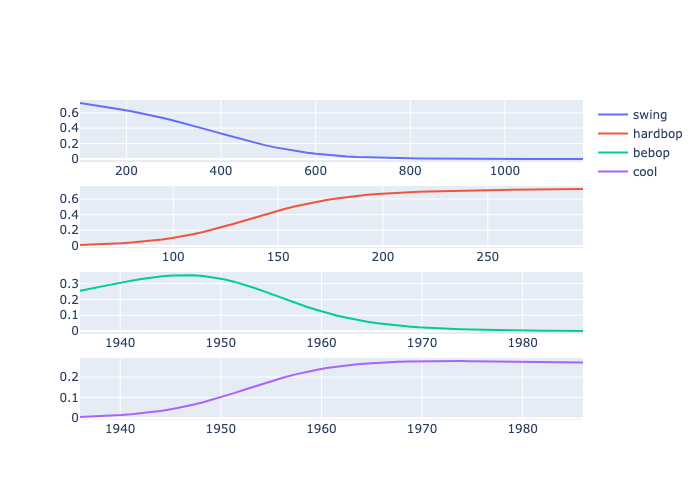

In [147]:
p=fit4.params.to_numpy()

x1 = np.linspace(test['tones'].min(),test['tones'].max())
x2 = np.linspace(test['tempo'].min(),test['tempo'].max())
x3 = np.linspace(test['year'].min(),test['year'].max())

exp1 = p[0,0]+p[1,0]*x1+p[2,0]*x2+p[3,0]*x3
exp2 = p[0,1]+p[1,1]*x1+p[2,1]*x2+p[3,1]*x3
exp3 = p[0,2]+p[1,2]*x1+p[2,2]*x2+p[3,2]*x3
predplot = make_subplots(rows=4,cols=1)

predplot.add_trace(go.Scatter(x=x1,y=(np.exp(exp1))/(1+np.exp(exp1)+np.exp(exp2)+np.exp(exp3)),name="swing"),row=1,col=1)
predplot.add_trace(go.Scatter(x=x2,y=(np.exp(exp2))/(1+np.exp(exp1)+np.exp(exp2)+np.exp(exp3)),name="hardbop"),row=2,col=1)
predplot.add_trace(go.Scatter(x=x3,y=(np.exp(exp3))/(1+np.exp(exp1)+np.exp(exp2)+np.exp(exp3)),name="bebop"),row=3,col=1)
predplot.add_trace(go.Scatter(x=x3,y=((1)/(1+np.exp(exp1)+np.exp(exp2)+np.exp(exp3))),name="cool"),row=4,col=1)
predplot.show("png")

# ROC and AUC

In [148]:
test_dummies = pd.get_dummies(test['style'],dtype=float).to_numpy()

pred_dummies = np.zeros(np.shape(test_dummies))
for i in range(np.size(test_score)):
    for j in range(np.shape(pred_dummies)[1]):
        if test_score[i]==j:
            pred_dummies[i,j]=1

In [149]:
fpr0, tpr0, thresholds0 = roc_curve(test_dummies[:,0],pred_dummies[:,0])
figroc0 = px.area(
    x=fpr0, y=tpr0,
    title=f'ROC Curve for "Cool" (AUC={auc(fpr0, tpr0):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
figroc0.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

figroc0.update_yaxes(scaleanchor="x", scaleratio=1)
figroc0.update_xaxes(constrain='domain')
figroc0.show()

In [150]:
fpr1, tpr1, thresholds1 = roc_curve(test_dummies[:,1],pred_dummies[:,1])
figroc1 = px.area(
    x=fpr1, y=tpr1,
    title=f'ROC Curve for "Swing" (AUC={auc(fpr1, tpr1):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
figroc1.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

figroc1.update_yaxes(scaleanchor="x", scaleratio=1)
figroc1.update_xaxes(constrain='domain')
figroc1.show()

In [151]:
fpr2, tpr2, thresholds2 = roc_curve(test_dummies[:,2],pred_dummies[:,2])
figroc2 = px.area(
    x=fpr2, y=tpr2,
    title=f'ROC Curve for "Hardbop" (AUC={auc(fpr2, tpr2):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
figroc2.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

figroc2.update_yaxes(scaleanchor="x", scaleratio=1)
figroc2.update_xaxes(constrain='domain')
figroc2.show()

In [152]:
fpr3, tpr3, thresholds3 = roc_curve(test_dummies[:,3],pred_dummies[:,3])
figroc3 = px.area(
    x=fpr3, y=tpr3,
    title=f'ROC Curve for "Bebop" (AUC={auc(fpr3, tpr3):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
figroc3.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

figroc3.update_yaxes(scaleanchor="x", scaleratio=1)
figroc3.update_xaxes(constrain='domain')
figroc3.show()

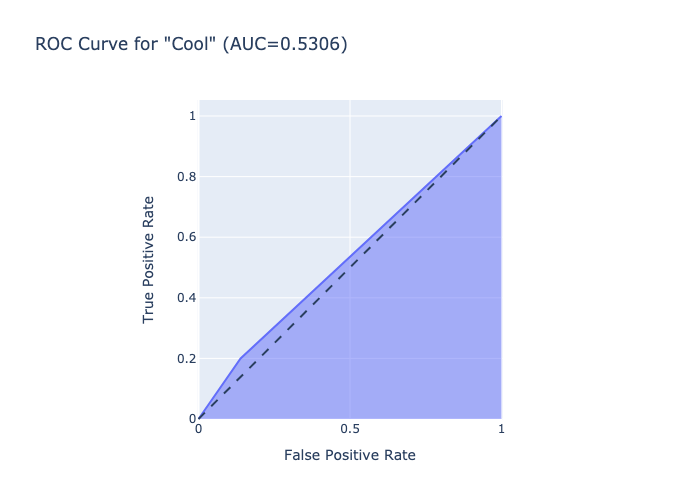

In [153]:
figroc0.show("png")

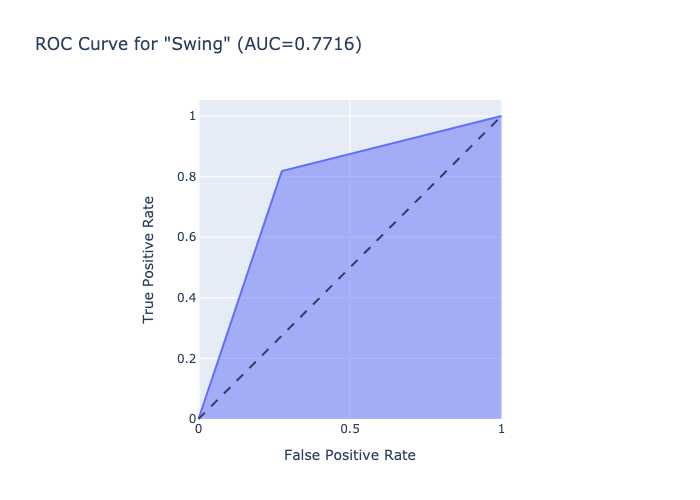

In [154]:
figroc1.show("png")

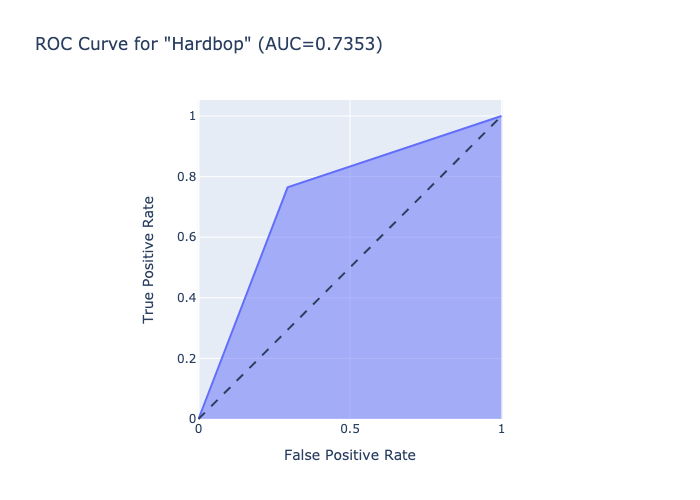

In [155]:
figroc2.show("png")

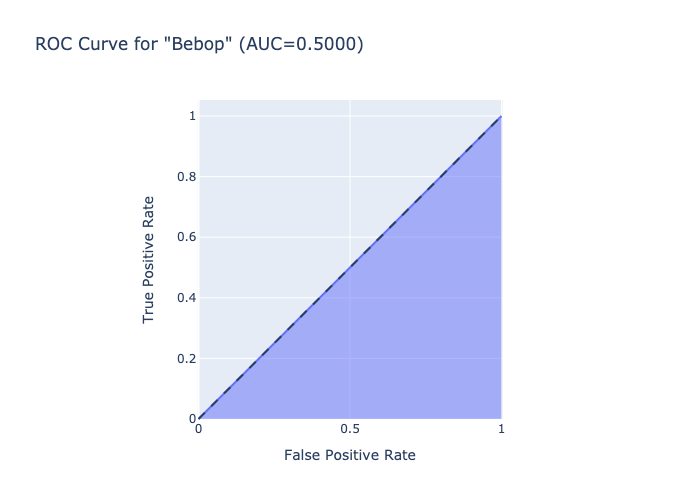

In [156]:
figroc3.show("png")